In [1]:
import numpy as np
import os
import torch
import taco_layers
import importlib
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
import IPython


In [2]:
hparams = {
                "num_domains": 8,
                "use_cuda": True,
                "symbols": "_ ~*.,;:?!-()\"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАЯОЁУЮЫИЭЕ^&$1234",
                "symbols_embedding_dim": 512,
                "E": 512,
                "ref_enc_filters": [32, 32, 64, 64, 128, 128],
                "ref_enc_size": [3, 3],
                "ref_enc_strides": [2, 2],
                "ref_enc_pad": [1, 1],
                "ref_enc_gru_size": 512,
                "token_num": 10,
                "num_heads": 8,
                "encoder_kernel_size": 5,
                "encoder_n_convolutions": 3,
                "encoder_embedding_dim": 512,
                "text_encoder_embedding_dim": 384,
                "decoder_rnn_dim": 800,
                "prenet_dim": 200,
                "max_decoder_steps": 1000,
                "gate_threshold": 0.5,
                "p_attention_dropout": 0.1,
                "p_decoder_dropout": 0.1,
                "n_mel_channels": 80,
                "num_f0_clusters": 11,
                "attention_rnn_dim": 800,
                "attention_dim": 128,
                "attention_location_n_filters": 32,
                "attention_location_kernel_size": 31,
                "postnet_embedding_dim": 512,
                "postnet_kernel_size": 5,
                "postnet_n_convolutions": 5,
                "batch_size": 64,
                "mask_padding": True,
                "dropout": 0.2
}

letter2index = {hparams['symbols'][i]: i for i in range(len(hparams['symbols']))}

In [3]:
class OneStepDecoder(torch.nn.Module):
    def __init__(self, hparams):
        super(OneStepDecoder, self).__init__()
        self.decoder = taco_layers.Decoder(hparams)

    def forward(self, spec,
                attention_hidden,
                attention_cell,
                decoder_hidden,
                decoder_cell,
                attention_weights,
                attention_weights_cum,
                attention_context,
                processed_memory,
                encoder_outputs):
        finished = False

        decoder_inputs = spec, attention_hidden, attention_cell, decoder_hidden, decoder_cell, attention_weights, attention_weights_cum, attention_context, processed_memory, encoder_outputs
        decoder_outputs = self.decoder(*decoder_inputs)
        spec, gate_output, attention_hidden, attention_cell, decoder_hidden, decoder_cell, attention_weights, attention_weights_cum, attention_context, processed_memory = decoder_outputs
        finished = bool(torch.sigmoid(gate_output[0]) > 0.6)
        return finished, spec, gate_output, attention_hidden, attention_cell, decoder_hidden, decoder_cell, attention_weights, attention_weights_cum, attention_context, processed_memory


In [6]:
tacotron2 = taco_layers.OwnTacotron2(hparams)
print(tacotron2)

encoder = taco_layers.Encoder(hparams)
decoder = OneStepDecoder(hparams)
postnet = taco_layers.Postnet(hparams)


OwnTacotron2(
  (embedding): Embedding(64, 512)
  (domain_embedding): Embedding(8, 64)
  (quantization_embeddings): ModuleList(
    (0): Embedding(6, 8)
    (1): Embedding(6, 16)
    (2): Embedding(6, 8)
    (3): Embedding(6, 16)
    (4): Embedding(6, 16)
  )
  (gst): GST(
    (encoder): ReferenceEncoder(
      (convs): ModuleList(
        (0): Conv1d(80, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
        (4): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
        (5): Conv1d(128, 128, kernel_size=(3,), stride=(2,), padding=(1,))
      )
      (bns): ModuleList(
        (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [8]:
taco_checkpoint_path = 'tacotron2.ckpt'
tacotron2.load_state_dict(torch.load(taco_checkpoint_path, map_location='cpu'))
tacotron2.eval()

encoder.load_state_dict(tacotron2.encoder.state_dict())
encoder.eval()
decoder.load_state_dict(tacotron2.state_dict(), strict=False)
decoder.eval()
postnet.load_state_dict(tacotron2.postnet.state_dict())
postnet.eval()

gst = tacotron2.tp
letter_embedder = tacotron2.embedding

In [7]:
eos = '~'
text = "всЕм привЕт, тэстИруем сИнтэз рЕчи?" + eos
letter_ids = [letter2index[l] for l in text]
speaker_id = 0
print(letter_ids)

[16, 32, 56, 27, 1, 30, 31, 23, 16, 56, 33, 5, 1, 33, 44, 32, 33, 54, 31, 34, 19, 27, 1, 32, 54, 28, 33, 44, 22, 1, 31, 56, 38, 23, 8, 2]


In [9]:
def synthesize(letter_ids, speaker_id):
    letter_embeddings = letter_embedder(torch.tensor([letter_ids])).transpose(1, 2)
    text_encoder_output = encoder(letter_embeddings, speaker_id)
    style_embedding = gst(text_encoder_output)

    encoder_output = text_encoder_output + style_embedding.repeat((1, text_encoder_output.shape[1], 1))
    print(encoder_output.shape)
    log_spectrogram, gate_output, alignment = tacotron2.decoder.infer(encoder_output)  # full decoder
    postnet_residual = postnet(log_spectrogram)
    log_spectrogram_postnet = log_spectrogram + postnet_residual
    
    return log_spectrogram_postnet, gate_output, alignment

/Users/sterling-gg/Downloads/ipython_notebooks/taco_layers.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((outputs.clone().detach(), torch.tensor(f0_embeddings).detach()), dim=2).clone().detach()


torch.Size([1, 36, 512])


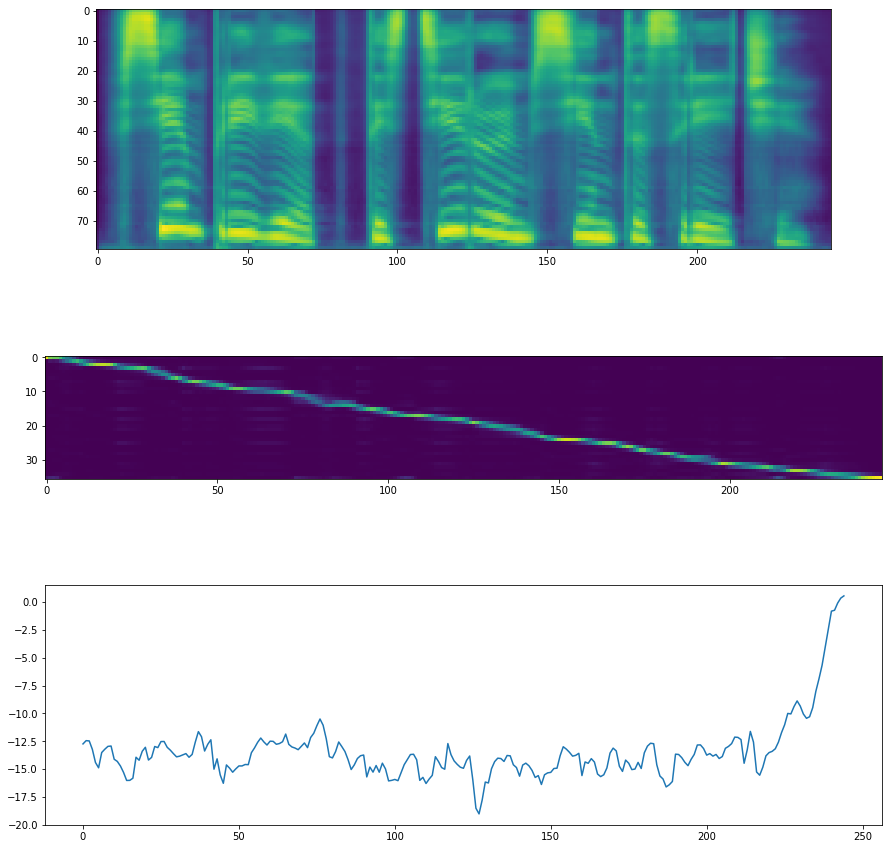

In [11]:
speaker_id = 0
log_spectrogram_postnet_female, gate_output, alignment_female = synthesize(letter_ids, speaker_id)

plt.figure(figsize=(15, 15))
plt.subplot(311)
plt.imshow(log_spectrogram_postnet_female.detach().numpy()[0][::-1])
plt.subplot(312)
plt.imshow(alignment_female.detach().numpy()[0].T)
plt.subplot(313)
plt.plot(gate_output.detach().numpy()[0])



In [12]:
def load_lpcnet(speaker_id):
    if speaker_id == 0:
        module_spec = importlib.util.spec_from_file_location("pylpcnet", 'pylpcnet_female.so')
    else:
        module_spec = importlib.util.spec_from_file_location("pylpcnet", 'pylpcnet_male.so')
    lpcnet_bin_lib = importlib.util.module_from_spec(module_spec)
    module_spec.loader.exec_module(lpcnet_bin_lib)
    return lpcnet_bin_lib

lpcnet_female = load_lpcnet(speaker_id=0)
lpcnet_male = load_lpcnet(speaker_id=1)

In [15]:
import time 
t0 = time.time()
audio_female = lpcnet_female.synthesize(np.exp(log_spectrogram_postnet_female.detach().cpu().numpy()[0].T))
print('elapsed time:', time.time() - t0)

write('female.wav', 24000, audio_female)
IPython.display.Audio("female.wav")

elapsed time: 0.8123030662536621


In [16]:
log_spectrogram_postnet_male, _, alignment_male = synthesize(letter_ids, speaker_id=1)

audio_male = lpcnet_male.synthesize(np.exp(log_spectrogram_postnet_male.detach().cpu().numpy()[0].T))

write('male.wav', 24000, audio_male)
IPython.display.Audio("male.wav")

/Users/sterling-gg/Downloads/ipython_notebooks/taco_layers.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.cat((outputs.clone().detach(), torch.tensor(f0_embeddings).detach()), dim=2).clone().detach()


torch.Size([1, 36, 512])


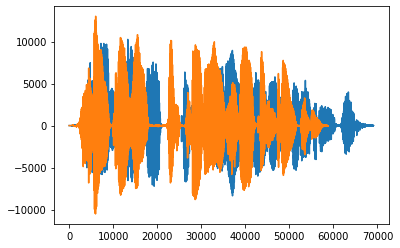

In [17]:
plt.plot(audio_male)
plt.plot(audio_female)

In [18]:
def synthesize_force_alignment(letter_ids, speaker_id, alignment):
    letter_embeddings = letter_embedder(torch.tensor([letter_ids])).transpose(1, 2)
    text_encoder_output = encoder(letter_embeddings, speaker_id)
    style_embedding = gst(text_encoder_output)

    encoder_output = text_encoder_output + style_embedding.repeat((1, text_encoder_output.shape[1], 1))
    print(encoder_output.shape)
    log_spectrogram, gate_output, alignment = tacotron2.decoder.infer_force_alignment(encoder_output, alignment)  # full decoder
    postnet_residual = postnet(log_spectrogram)
    log_spectrogram_postnet = log_spectrogram + postnet_residual
    
    return log_spectrogram_postnet, gate_output, alignment

torch.Size([1, 36, 512])


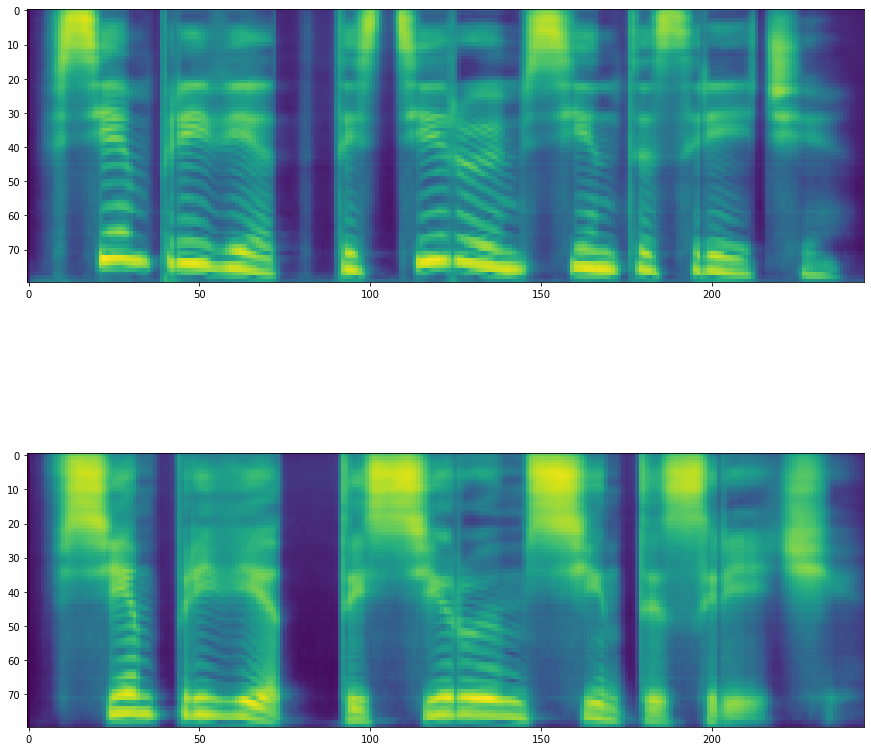

In [21]:
log_spectrogram_postnet_male_forced, _, _ = \
    synthesize_force_alignment(letter_ids, speaker_id=1, alignment=alignment_female)

plt.figure(figsize=(15, 15))
plt.subplot(211)
plt.imshow(log_spectrogram_postnet_female.detach().numpy()[0][::-1])
plt.subplot(212)
plt.imshow(log_spectrogram_postnet_male_forced.detach().numpy()[0][::-1])


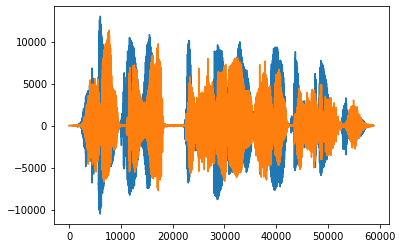

In [22]:
audio_forced = lpcnet_male.synthesize(np.exp(log_spectrogram_postnet_male_forced.detach().cpu().numpy()[0].T))

plt.plot(audio_female)
plt.plot(audio_forced)

write('male_forced.wav', 24000, audio_forced)
IPython.display.Audio("male_forced.wav")

In [23]:
write('chorus.wav', 24000, audio_forced + audio_female)
IPython.display.Audio("chorus.wav")